# DeiT models analysis

Import all the necessary libraries

In [33]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torchvision
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from models_v2 import *

## DEIT-III pre-trained - artifacts visualization

In [4]:
def show_artifacts(
    test_model: nn.Module, test_image: torch.Tensor, log_scale=False, token: int = 0
) -> None:
    """
    Generate the Attention maps and the norm values for the DEIT-III model

    test_model: DEIT-III model to be tested,
    test_image: Image of the correct size for the corresponding model, and batch dimension is accounted for
    log_scale: If True, the log of the attention map values will be displayed
    token: The token to be visualized in the attention maps
    """

    test_model(test_image)
    num_blocks = len(test_model.blocks)

    ## 1. Norm of feature values after MLP - TODO: double check - isn't it before MLP as it's the last block?
    print("Norm of feature values after MLP")
    output = test_model.block_output[f"block{num_blocks-1}"]
    output = output.squeeze(0)
    output = output[1:]
    # copmute norm of all output elements
    output_norms = output.norm(dim=-1)
    # output_norms.shape

    plt.imshow(output_norms.reshape(24, 24).detach().numpy())
    plt.axis("off")
    plt.colorbar(label="Norm Values")  # add a colorbar as a legend
    plt.show()

    plt.hist(output_norms.detach().numpy(), bins=50)
    plt.xlabel("Norm Values")
    plt.ylabel("Frequency")
    plt.show()
    #########################################################################################################

    ## 2. Attention maps for the last Attention Head
    print("Attention maps for the last Attention Head")
    attn_map_mean = (
        test_model.blocks[num_blocks - 1].attn.attn_map.squeeze(0).mean(dim=0)
    )
    attn_map_mean = attn_map_mean[token][1:]
    if log_scale:
        attn_map_mean = torch.log(attn_map_mean + 1e-6)
    # attn_map_mean.shape

    plt.imshow(attn_map_mean.reshape(24, 24).detach().numpy())
    plt.axis("off")
    plt.colorbar(label="CLS attention map")
    plt.show()
    #########################################################################################################

    ## 3. All attention maps
    print("All attention maps")

    num_cols = 6
    num_rows = (
        num_blocks + num_cols - 1
    ) // num_cols  # calculate the number of rows needed
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 2.5))
    axes = axes.flatten()

    for i in range(num_blocks):
        attn_map = test_model.blocks[i].attn.attn_map.squeeze(0).mean(dim=0)
        attn_map = attn_map[token][1:]
        attn_map_img = attn_map.reshape(24, 24).detach().numpy()

        axes[i].imshow(attn_map_img)
        axes[i].axis("off")
        axes[i].set_title(f"Block {i+1}")

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

    #########################################################################################################

In [5]:
# NOTE: Should we keep it? It's not used anywhere
def show_all_tokens(test_model: nn.Module) -> None:
    ## Attention maps, last layer, all tokens
    num_tokens = 24 * 24
    num_cols = 6
    num_rows = (
        num_tokens + num_cols - 1
    ) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 2.5))
    axes = axes.flatten()

    for i in range(num_tokens):
        attn_map = (
            test_model.blocks[len(test_model.blocks) - 1]
            .attn.attn_map.squeeze(0)
            .mean(dim=0)
        )
        attn_map = attn_map[i][1:]
        attn_map_img = attn_map.reshape(24, 24).detach().numpy()

        axes[i].imshow(attn_map_img)
        axes[i].axis("off")
        axes[i].set_title(f"Token {i+1}")

#### Choose DeiT version (size)

In [6]:
model_size = "small"

if model_size == "tiny":
    chosen_model = deit_tiny_patch16_LS(
        pretrained=True, img_size=384, pretrained_21k=True
    )
elif model_size == "small":
    chosen_model = deit_small_patch16_LS(
        pretrained=True, img_size=384, pretrained_21k=True
    )
elif model_size == "base":
    chosen_model = deit_base_patch16_LS(
        pretrained=True, img_size=384, pretrained_21k=True
    )
elif model_size == "large":
    chosen_model = deit_large_patch16_LS(
        pretrained=True, img_size=384, pretrained_21k=True
    )
else:
    raise ValueError("Invalid model size: choose from 'tiny', 'small', 'base', 'large'")

******************** PRETRAINED 21k MODEL WILL BE USED


In [7]:
print("Chosen model:", model_size.upper())
chosen_model

Chosen model: SMALL


vit_models(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x Layer_scale_init_Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (head): Linear(in_features=384, ou

#### Choose an image for the analysis

In [8]:
def get_image(image_path: str) -> torch.Tensor:
    """Load an image, resize, normalize, and convert to a tensor with a batch dimension."""
    img = Image.open(image_path).convert("RGB")
    img = img.resize((384, 384))
    img = np.array(img).transpose(
        2, 0, 1
    )  # convert to numpy and rearrange dimensions
    img = (
        torch.tensor(img, dtype=torch.float32) / 255.0
    )  # normalize and convert to tensor
    return img.unsqueeze(0)  # Add batch dimension


def plot_image(image_tensor: torch.Tensor) -> None:
    """Plot a single image tensor."""
    image_np = (
        image_tensor.permute(1, 2, 0).clip(0, 1).numpy()
    )  # Convert to (H, W, C) and clip values
    plt.imshow(image_np)
    plt.axis("off")
    plt.show()

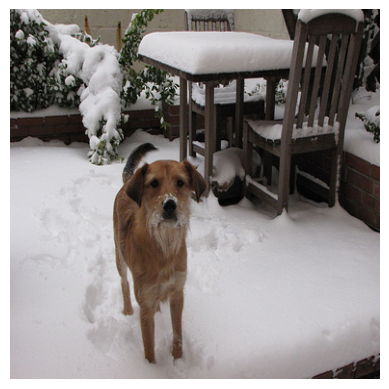

In [9]:
image_path = "./images/dog.JPEG"
img = get_image(image_path)
plot_image(img.squeeze(0))

In [10]:
# final output shape
chosen_model(img).shape

torch.Size([1, 1000])

### Artifacts visualization

Norm of feature values after MLP


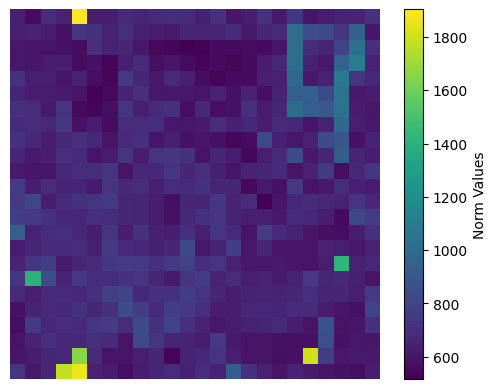

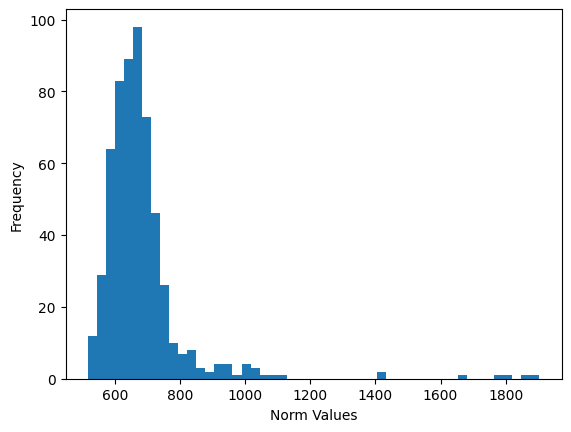

Attention maps for the last Attention Head


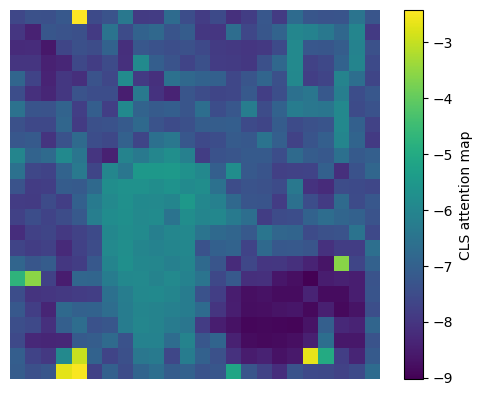

All attention maps


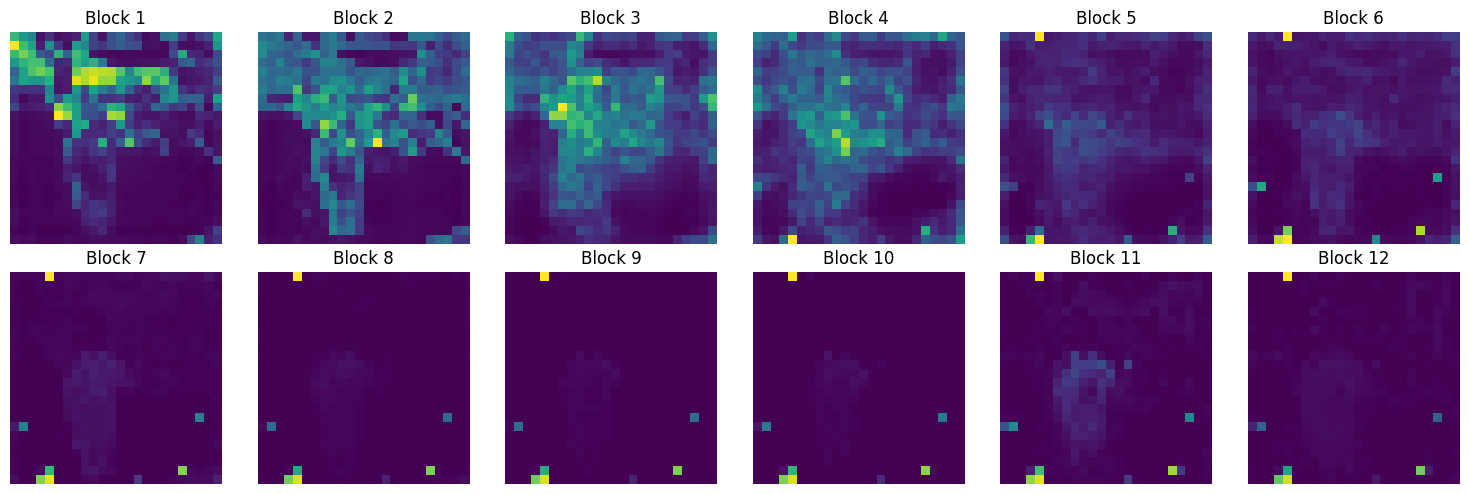

In [11]:
show_artifacts(test_model=chosen_model, test_image=img, log_scale=True, token = 0)

### TODO: clarify (High-Attention Patches with Local Feature Norms)

(576, 576)
(1, 577, 384)
(24, 24)
Mean norm for high-attention patches: 685.1310424804688


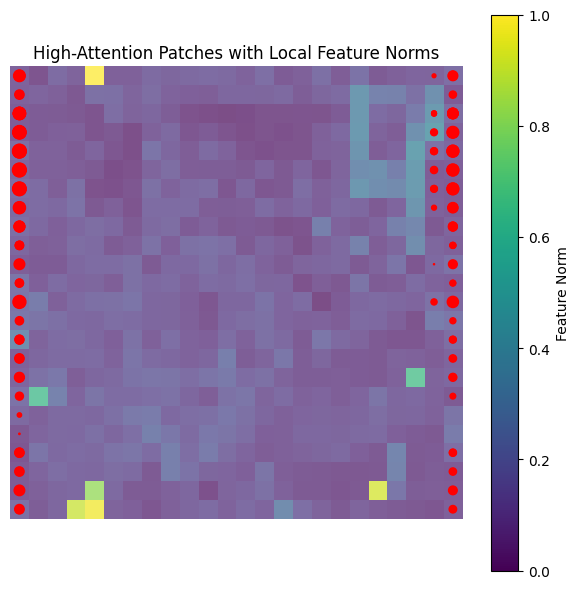

In [12]:
combined_attention = chosen_model.blocks[11].attn.attn_map.squeeze(0).mean(dim=0)[1:, 1:].detach().numpy()
print(combined_attention.shape)
print(chosen_model.block_output["block11"].detach().numpy().shape)

local_feature_norms = (
    chosen_model.block_output["block11"]
    .squeeze(0)
    .norm(dim=-1)[1:]
    .reshape(24, 24)
    .detach()
    .numpy()
)
print(local_feature_norms.shape)

################################################################################

high_attention_threshold = np.percentile(combined_attention, 99.9)
high_attention_indices = np.where(combined_attention >= high_attention_threshold)

scale_factor = 24
scaled_attention_indices = (
    high_attention_indices[0] // scale_factor,
    high_attention_indices[1] // scale_factor,
)

attention_values = combined_attention[high_attention_indices]

high_attention_norms = local_feature_norms[scaled_attention_indices]

mean_high_attention_norm = np.mean(high_attention_norms)
print(f"Mean norm for high-attention patches: {mean_high_attention_norm}")

dot_sizes = (
    (attention_values - np.min(attention_values))
    / (np.max(attention_values) - np.min(attention_values))
    * 100
)

plt.figure(figsize=(6, 6))
plt.imshow(local_feature_norms, cmap="viridis", alpha=0.7)
plt.scatter(
    scaled_attention_indices[1], scaled_attention_indices[0], color="red", s=dot_sizes
)
plt.title("High-Attention Patches with Local Feature Norms")
plt.axis("off")
plt.colorbar(label="Feature Norm")
plt.tight_layout()
plt.show()

### Top norm tokens vs. their attention values
Find the intersection of high-norm and high-attention tokens from a selected attention block (last by default) and visualize it

In [13]:
def top_norm_tokens(test_model: nn.Module, block: int = None) -> np.ndarray:
    """Get sorted tokens with the highest norm values from the last block"""
    if block is None:
        block = len(test_model.blocks) - 1

    output = test_model.block_output["block" + str(block)]
    # output = output.squeeze(0)
    output = output[:, 1:]
    output_norms = output.norm(dim=-1)
    top_tokens = torch.argsort(output_norms, descending=True, dim=1)

    return top_tokens.cpu().numpy()


def top_attn_tokens(test_model: nn.Module, block: int = None) -> np.ndarray:
    """Get sorted tokens with the highest attention values from the last block"""
    if block is None:
        block = len(test_model.blocks) - 1
    attn_map_mean = test_model.blocks[block].attn.attn_map.mean(dim=1)
    top_tokens = torch.argsort(attn_map_mean[:, 0, 1:], descending=True)
    return top_tokens.cpu().numpy()


def find_high_norm_attn_intersection(test_model: nn.Module, block: int = None, top_n: int = 10) -> np.ndarray:
    """Find the intersection of top tokens with the highest norm and attention values"""
    intersection = []
    top_norm = top_norm_tokens(test_model, block)[:, :top_n]
    top_attn = top_attn_tokens(test_model, block)[:, :top_n]

    for i in range(top_norm.shape[0]):
        intersection.append(np.intersect1d(top_attn[i], top_norm[i]))
    return intersection

In [14]:
top10_attn_tokens = top_attn_tokens(chosen_model)[:, :10]
print(top10_attn_tokens)

top20_attn_tokens = top_attn_tokens(chosen_model)[:, :20]
print(top20_attn_tokens)

intersection = find_high_norm_attn_intersection(chosen_model)
print(intersection)

[[  4 556 547 555 532 409 405 408 548 566]]
[[  4 556 547 555 532 409 405 408 548 566 250 299 248 249 274 272 251 271
  295 391]]
[array([  4, 405, 409, 532, 547, 555, 556])]


In [15]:
def plot_feature_norms_with_high_attn(
    output_tensor: torch.Tensor,
    high_attn_tokens: torch.Tensor,
    grid_size: tuple = (24, 24),
    dot_color: str = "red",
    dot_size: int = 30,
    label: str = "High Attention Tokens",
) -> None:
    """
    Plots the norm of feature values from a model's MLP output, with red dots indicating high attention tokens.

    :param output_tensor: The output tensor from the model's MLP layer
    :param high_attn_tokens: The indices of the high attention tokens
    :param grid_size: The size of the grid to reshape the output tensor
    :param dot_color: The color of the high attention points
    :param dot_size: The size of the high attention points
    """
    # squeeze and remove the CLS token
    output = output_tensor.squeeze(0)[1:]
    # compute norm of all output elements
    output_norms = output.norm(dim=-1)

    # plot the norm values as an image
    plt.imshow(output_norms.reshape(grid_size).detach().numpy())
    plt.axis("off")
    plt.colorbar(label="Norm Values")

    # highlight high attention points with red dots
    high_attn_indices = np.unravel_index(high_attn_tokens[0], grid_size)
    plt.scatter(
        high_attn_indices[1],
        high_attn_indices[0],
        color=dot_color,
        s=dot_size,
        label=label,
    )
    plt.legend(loc="upper right")
    plt.show()

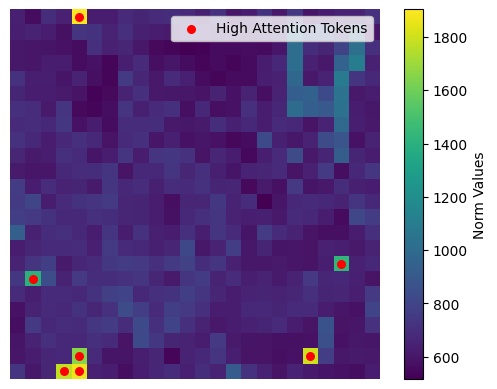

In [16]:
# NOTE: I think we should stick to the top 10/20 high-attention tokens, cause taking the intersection is kinda cheating 😬
plot_feature_norms_with_high_attn(
    output_tensor=chosen_model.block_output["block11"],
    high_attn_tokens=intersection,
)

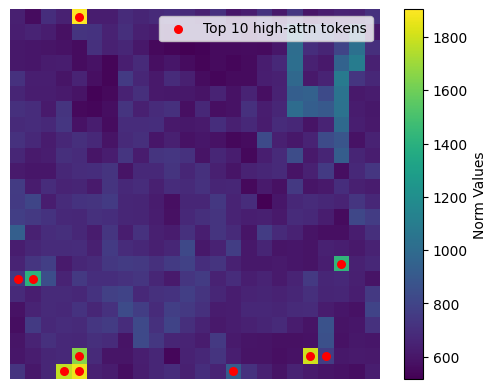

In [17]:
plot_feature_norms_with_high_attn(
    output_tensor=chosen_model.block_output["block11"],
    high_attn_tokens=top10_attn_tokens,
    label="Top 10 high-attn tokens",
)

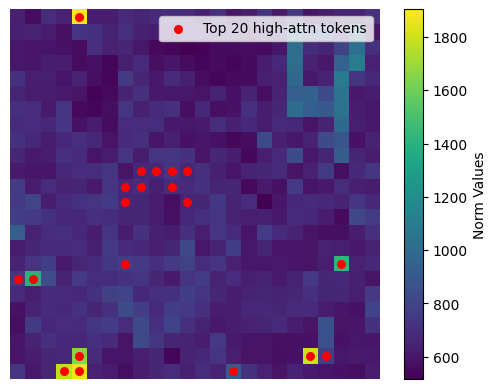

In [18]:
plot_feature_norms_with_high_attn(
    output_tensor=chosen_model.block_output["block11"],
    high_attn_tokens=top20_attn_tokens,
    label="Top 20 high-attn tokens",
)

### Check attention values of selected tokens across all blocks

In [19]:
def show_attn_progression(test_model: nn.Module, token: str="cls") -> None:

    ## All attention maps
    num_images = len(test_model.blocks)
    num_cols = 6
    num_rows = (
        num_images + num_cols - 1
    ) // num_cols  # calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 2.5))
    axes = axes.flatten()

    for i in range(num_images):
        attn_map = test_model.blocks[i].attn.attn_map.squeeze(0).mean(dim=0)
        if str(token) == "cls":
            attn_map = attn_map[0][1:]
        else:
            attn_map = attn_map[token + 1][1:]
        attn_map_img = attn_map.reshape(24, 24).detach().numpy()

        axes[i].imshow(attn_map_img)
        axes[i].axis("off")
        axes[i].set_title(f"Block {i+1}")

    # hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

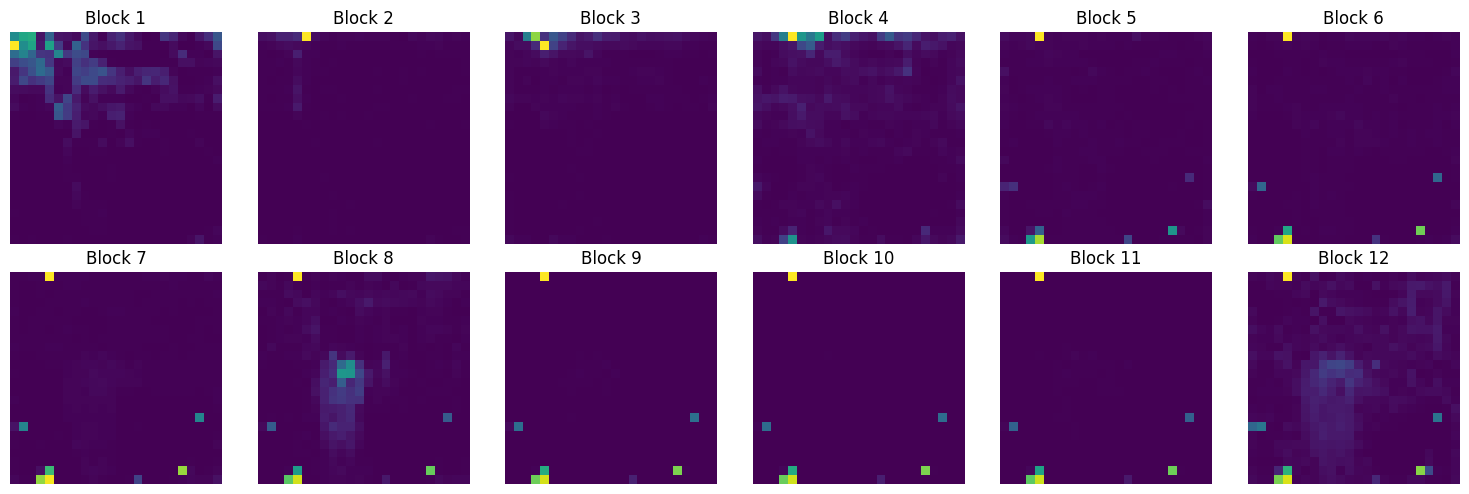

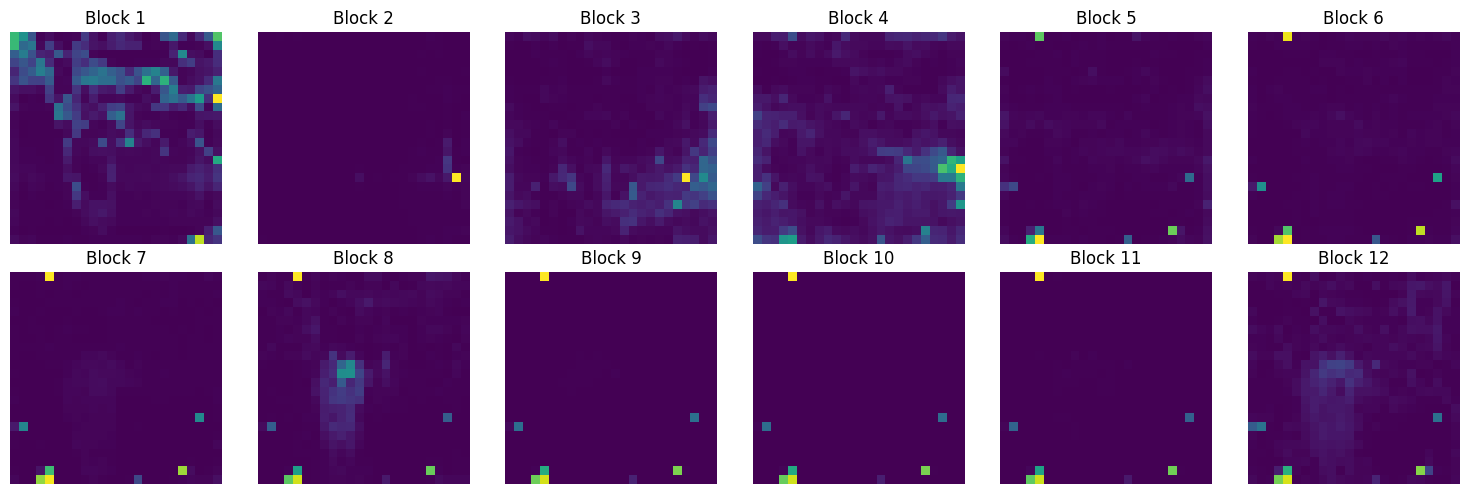

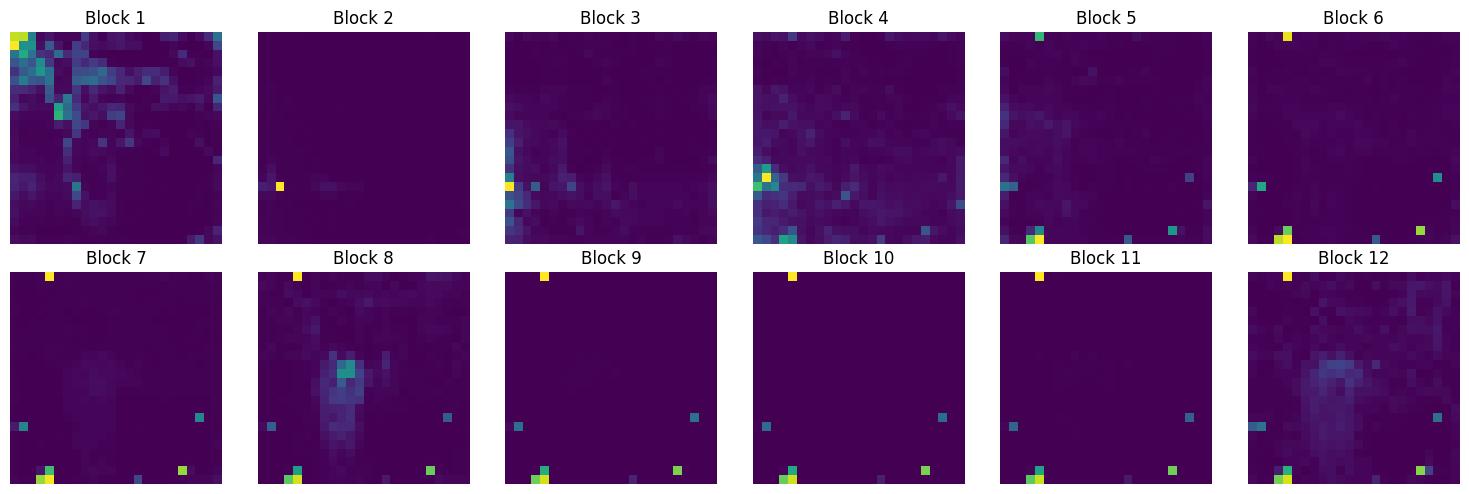

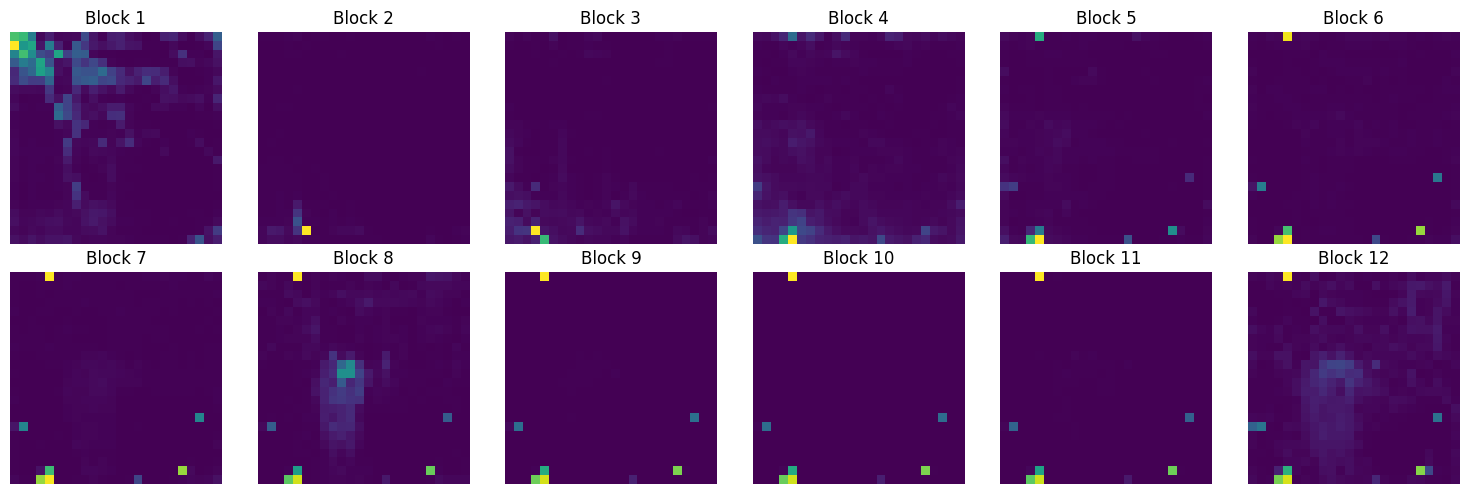

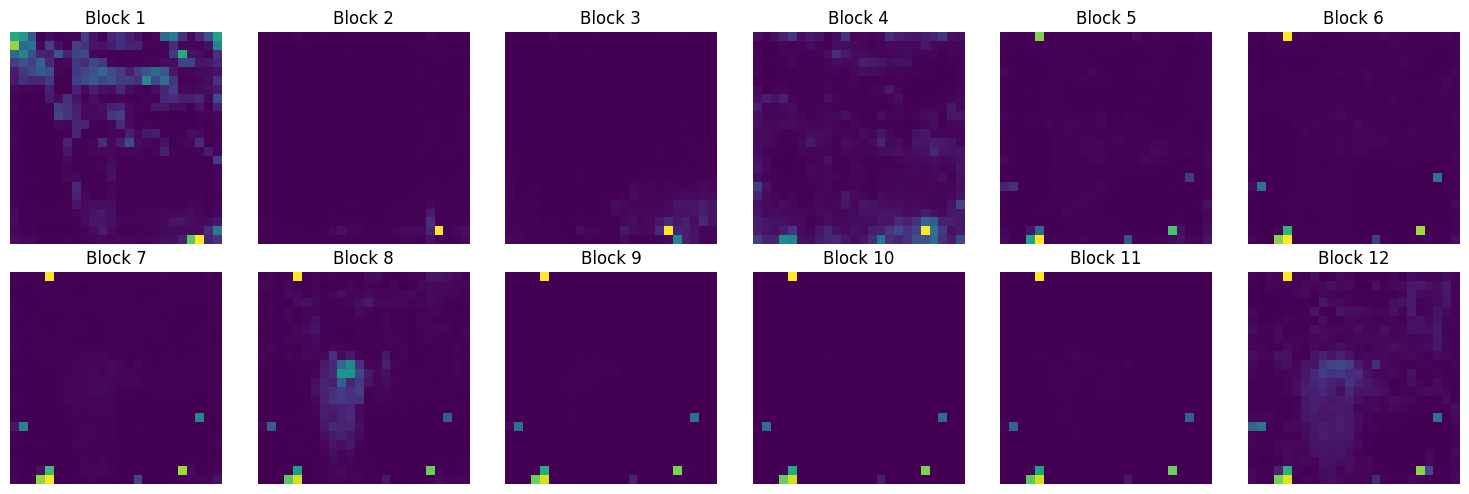

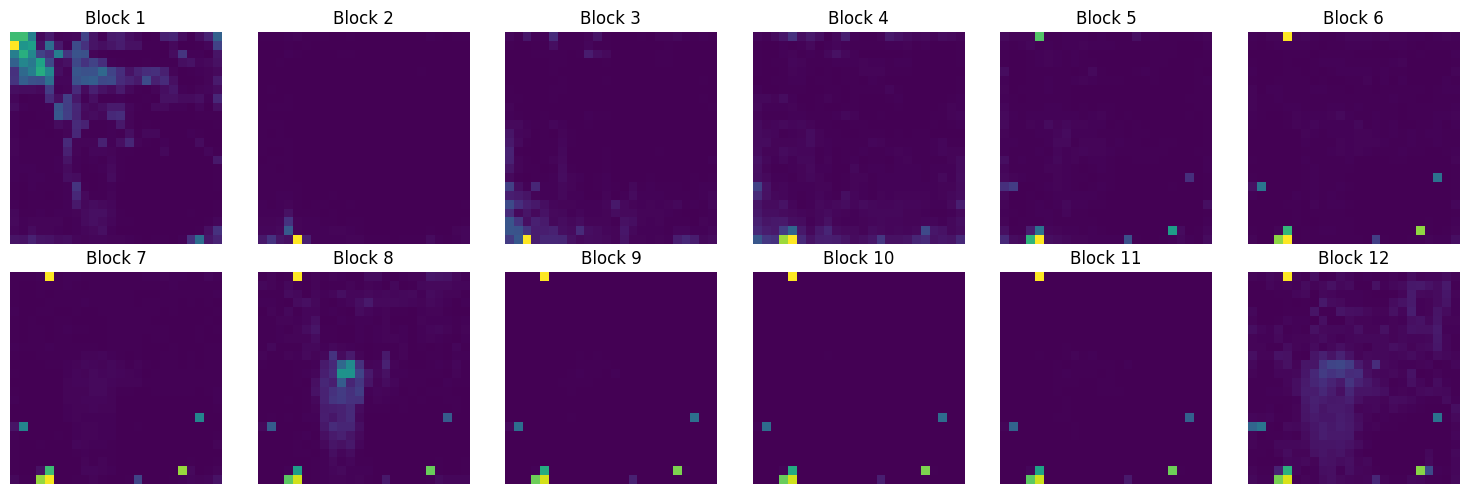

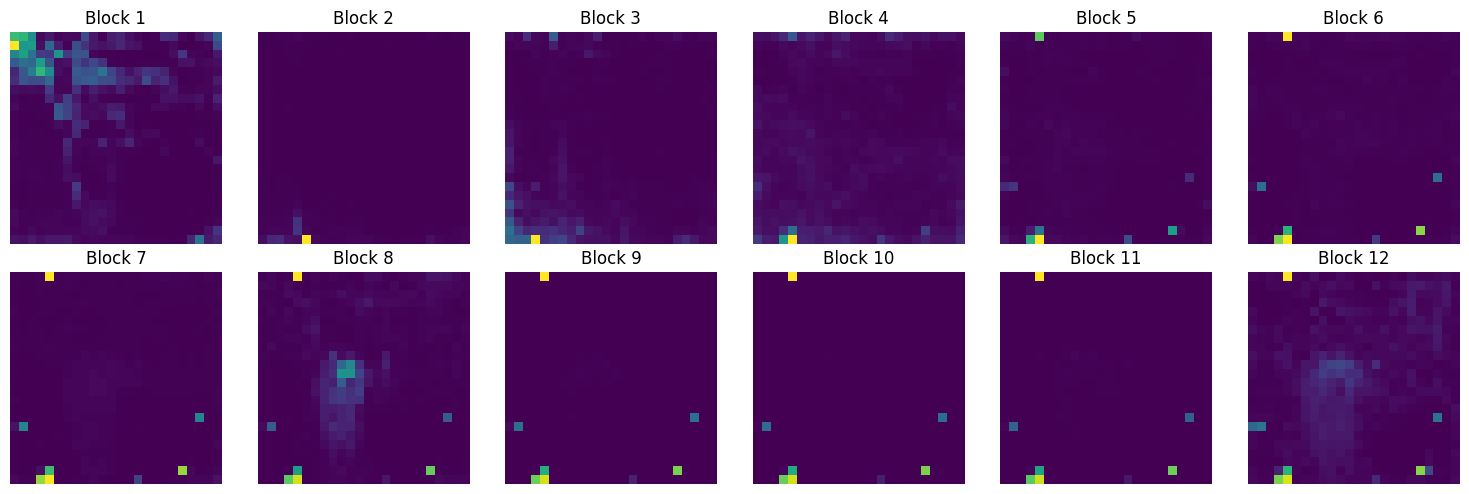

In [20]:
for x in intersection[0]:
    show_attn_progression(chosen_model, token = x)

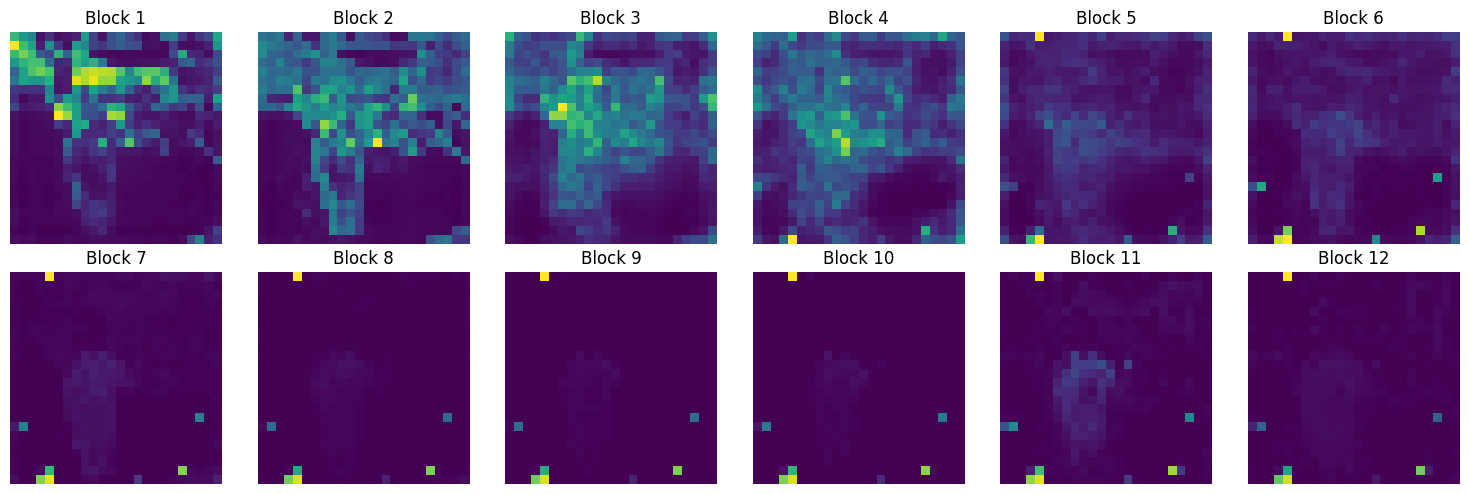

In [21]:
show_attn_progression(chosen_model, token = 'cls')

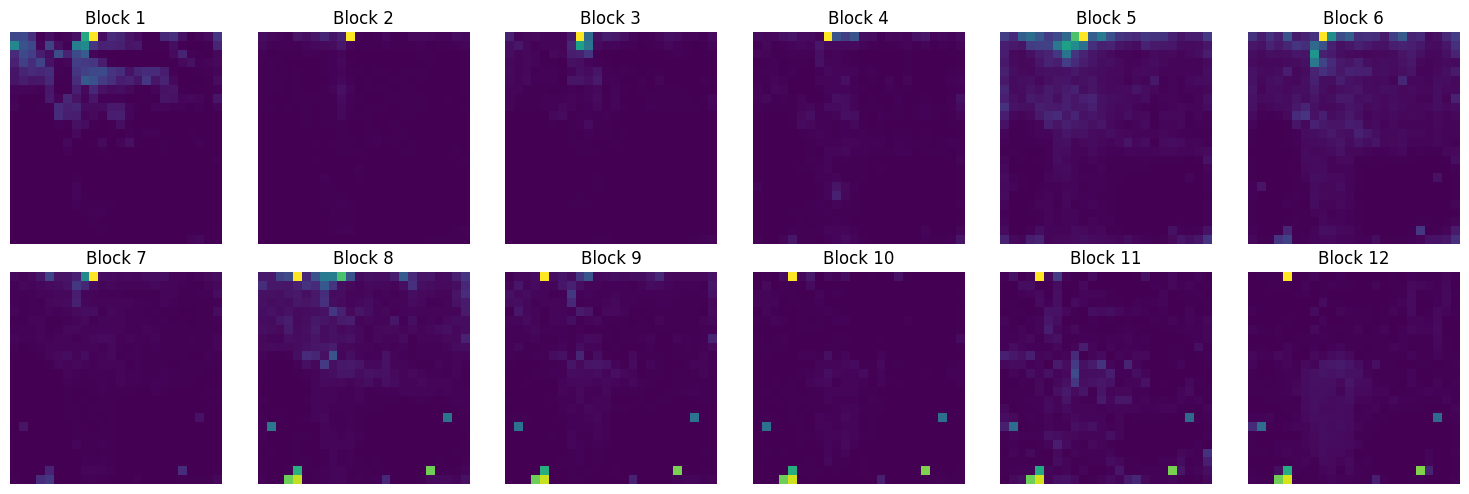

In [22]:
show_attn_progression(chosen_model, token = 9)

### Training logistic regression on high-norm and normal patches (CIFAR10)

In [23]:
use_mps = False
train_subset_size = 1500
test_subset_size = 400
batch_size = 16

if use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [35]:
# logistic regression norm-normal
print("Loading CIFAR-10 dataset...")
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

print(f"Creating subsets: {train_subset_size} training images, {test_subset_size} testing images...")
train_indices = torch.randperm(len(train_dataset))[:train_subset_size]
test_indices = torch.randperm(len(test_dataset))[:test_subset_size]

train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
print("Subsets and DataLoaders ready.")

print(f"\nLoading DeiT {model_size.upper()} model...")
model = chosen_model
model.to(device)
model.eval()
print(f"DeiT {model_size.upper()} model loaded and ready.")

Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified
Creating subsets: 100 training images, 400 testing images...
Subsets and DataLoaders ready.

Loading DeiT SMALL model...
DeiT SMALL model loaded and ready.


In [29]:
# Extract Patch Embeddings and Norms
high_norm_tokens = []
normal_tokens = []
labels_high = []  
labels_normal = [] 

print("Extracting patch embeddings...")
for batch_idx, (images, targets) in enumerate(train_loader):
    images = images.to(device)

    with torch.no_grad():
        model(images)
        # features = model.block_output['final']
        features = model.block_output['block11']
        
        patch_features = features[:, 1:, :]  
        norms = torch.norm(patch_features, dim=-1).cpu().numpy()

        for i in range(images.size(0)):  
            single_patch_features = patch_features[i]
            single_norms = norms[i]

            single_norms_tensor = torch.tensor(single_norms)
            top_tokens = torch.argsort(single_norms_tensor, descending=True)[:10].numpy()
            high_indices = np.where(single_norms > single_norms[top_tokens[-1]])[0]
            normal_indices = np.where(single_norms <= single_norms[top_tokens[-1]])[0]

            if high_indices.size > 0:
                high_norm_token = single_patch_features[high_indices[np.random.randint(len(high_indices))], :].cpu().numpy()
                high_norm_tokens.append(high_norm_token)
                labels_high.append(targets[i].item())

            if normal_indices.size > 0:
                normal_token = single_patch_features[normal_indices[np.random.randint(len(normal_indices))], :].cpu().numpy()
                normal_tokens.append(normal_token)
                labels_normal.append(targets[i].item())
    
    print(f"Processed batch {batch_idx + 1}/{len(train_loader)}")

print("Patch embedding extraction complete.")

print("Preparing datasets for Logistic Regression...")
X_high = np.array(high_norm_tokens)
X_normal = np.array(normal_tokens)
y_high = np.array(labels_high)
y_normal = np.array(labels_normal)

print(len(X_high), len(X_normal))
print(len(y_high), len(y_normal))

print("Splitting data into training and testing sets...")
X_high_train, X_high_test, y_high_train, y_high_test = train_test_split(X_high, y_high, test_size=0.2, random_state=42)
X_normal_train, X_normal_test, y_normal_train, y_normal_test = train_test_split(X_normal, y_normal, test_size=0.2, random_state=42)

Extracting patch embeddings...
Processed batch 1/94
Processed batch 2/94
Processed batch 3/94
Processed batch 4/94
Processed batch 5/94
Processed batch 6/94
Processed batch 7/94
Processed batch 8/94
Processed batch 9/94
Processed batch 10/94
Processed batch 11/94
Processed batch 12/94
Processed batch 13/94
Processed batch 14/94
Processed batch 15/94
Processed batch 16/94
Processed batch 17/94
Processed batch 18/94
Processed batch 19/94
Processed batch 20/94
Processed batch 21/94
Processed batch 22/94
Processed batch 23/94
Processed batch 24/94
Processed batch 25/94
Processed batch 26/94
Processed batch 27/94
Processed batch 28/94
Processed batch 29/94
Processed batch 30/94
Processed batch 31/94
Processed batch 32/94
Processed batch 33/94
Processed batch 34/94
Processed batch 35/94
Processed batch 36/94
Processed batch 37/94
Processed batch 38/94
Processed batch 39/94
Processed batch 40/94
Processed batch 41/94
Processed batch 42/94
Processed batch 43/94
Processed batch 44/94
Processed 

In [30]:
print("Training Logistic Regression classifiers...")
clf_high = LogisticRegression(max_iter=1000).fit(X_high_train, y_high_train)
print("High-Norm Token classifier trained.")

clf_normal = LogisticRegression(max_iter=1000).fit(X_normal_train, y_normal_train)
print("Normal Token classifier trained.")

print("Evaluating classifiers...")
high_acc = accuracy_score(y_high_test, clf_high.predict(X_high_test))
normal_acc = accuracy_score(y_normal_test, clf_normal.predict(X_normal_test))

print(f"High-Norm Token Accuracy: {high_acc:.4f}")
print(f"Normal Token Accuracy: {normal_acc:.4f}")

Training Logistic Regression classifiers...
High-Norm Token classifier trained.
Normal Token classifier trained.
Evaluating classifiers...
High-Norm Token Accuracy: 0.8467
Normal Token Accuracy: 0.7867


### Cosine similarity between high-norm/normal patches and their neighbours

In [24]:
# NOTE: we base it on just one image, is it ok/reliable? (though in the paper they do it in the same manner I think, judging by the density values)
embedding = chosen_model.patch_embed(img).squeeze(0)
top_norm = top_norm_tokens(chosen_model)[0, :10]

In [25]:
all_tokens = dict()
for x in range(24 * 24):
    emb = embedding[x].detach()
    right = embedding[(x + 1) % (24 * 24)]
    left = embedding[x - 1]
    up = embedding[x - 24]
    down = embedding[(x + 24) % (24 * 24)]

    cos_sim = torch.nn.CosineSimilarity(dim=0)
    mean_sim = (
        cos_sim(emb, right) + cos_sim(emb, left) + cos_sim(emb, up) + cos_sim(emb, down)
    ) / 4

    all_tokens[x] = mean_sim.detach().numpy()

In [26]:
top_norm_keys = set(top_norm)
top_norm_similarities = [all_tokens[key] for key in top_norm_keys]

not_top_norm_keys = set(all_tokens.keys()) - top_norm_keys
not_top_norm_similarities = [all_tokens[key] for key in not_top_norm_keys]

top_norm_similarities = [float(similarity) for similarity in top_norm_similarities]
not_top_norm_similarities = [
    float(similarity) for similarity in not_top_norm_similarities
]

In [27]:
def plot_similarity_density(top_norm_similarities: list, not_top_norm_similarities: list) -> None:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(not_top_norm_similarities, label='normal patches', color='blue', bw_adjust=0.5)
    sns.kdeplot(top_norm_similarities, label='artifact patches', color='orange', bw_adjust=0.5)

    plt.xlabel("Cosine similarity")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

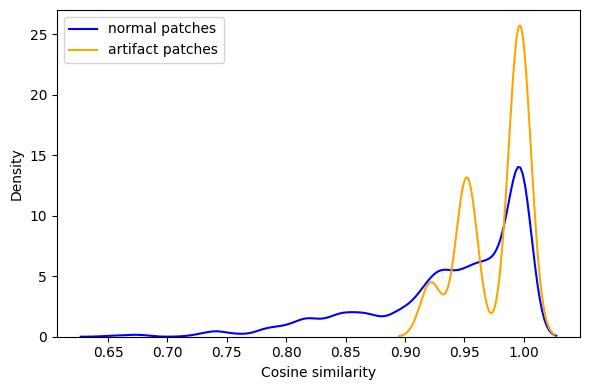

In [28]:
plot_similarity_density(top_norm_similarities, not_top_norm_similarities)

### training position

In [39]:
from torch.utils.data import Subset, DataLoader
from torchvision import transforms
import torchvision

# logistic regression norm-normal 
print("Loading CIFAR-10 dataset...")
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_subset_size = 1000
test_subset_size = 10
print(f"Creating subsets: {train_subset_size} training images, {test_subset_size} testing images...")
train_indices = torch.randperm(len(train_dataset))[:train_subset_size]
test_indices = torch.randperm(len(test_dataset))[:test_subset_size]
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

batch_size = 16
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
print("Subsets and DataLoaders ready.")

print("Loading model...")
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps')
model = chosen_model
model.to(device)
model.eval()
print("Model loaded and ready.")

Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified
Creating subsets: 1000 training images, 10 testing images...
Subsets and DataLoaders ready.
Loading model...
Model loaded and ready.


In [41]:
# put all elements of the train loader in a single ndarray
print("Extracting patch embeddings...")
patch_embeddings = dict()
patch_embeddings = dict()
artifact_indices = dict()
for batch_idx, (images, targets) in enumerate(train_loader):
    images = images.to(device)
    with torch.no_grad():
        chosen_model(images)
    for block in range(12):
        if block not in patch_embeddings:
            patch_embeddings[block] = []
        patch_embeddings[block].append(chosen_model.block_output[f'block{block}'][:,1:,:].cpu().numpy())
        artifacts = find_high_norm_attn_intersection(chosen_model, block = block)

        for i in range(images.size(0)):
            if block not in artifact_indices:
                artifact_indices[block] = []
            artifact_indices[block].append(artifacts[i])
            

            
    print(f"Processed batch {batch_idx + 1}/{len(train_loader)}")

for block in range(12):
    patch_embeddings[block] = np.concatenate(patch_embeddings[block], axis=0)

print("Patch embeddings extracted.")


Extracting patch embeddings...
Processed batch 1/63
Processed batch 2/63
Processed batch 3/63
Processed batch 4/63
Processed batch 5/63
Processed batch 6/63
Processed batch 7/63
Processed batch 8/63
Processed batch 9/63
Processed batch 10/63
Processed batch 11/63
Processed batch 12/63
Processed batch 13/63
Processed batch 14/63
Processed batch 15/63
Processed batch 16/63
Processed batch 17/63
Processed batch 18/63
Processed batch 19/63
Processed batch 20/63
Processed batch 21/63
Processed batch 22/63
Processed batch 23/63
Processed batch 24/63
Processed batch 25/63
Processed batch 26/63
Processed batch 27/63
Processed batch 28/63
Processed batch 29/63
Processed batch 30/63
Processed batch 31/63
Processed batch 32/63
Processed batch 33/63
Processed batch 34/63
Processed batch 35/63
Processed batch 36/63
Processed batch 37/63
Processed batch 38/63
Processed batch 39/63
Processed batch 40/63
Processed batch 41/63
Processed batch 42/63
Processed batch 43/63
Processed batch 44/63
Processed 

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

y = np.array(range(576))
y = np.tile(y, 1000)
X = patch_embeddings[block].reshape(-1, patch_embeddings[block].shape[-1])
indices = np.random.choice(X.shape[0], 10 * 1000, replace=False)


for block in range(12):
    print(f"Training Linear Regression for block {block}...")
    X = patch_embeddings[block].reshape(-1, patch_embeddings[block].shape[-1])


    indices = np.random.choice(X.shape[0], 10000, replace=False)
    X_test = X[indices]
    y_test = y[indices]
    X_train = X[[index for index in range(X.shape[0]) if index not in indices]]
    y_train = y[[index for index in range(y.shape[0]) if index not in indices]]

    X_test_artifact = []
    y_test_artifact = []

    for index, x in enumerate(X_test):
        image_number = indices[index] // 576
        artifact_tokens = artifact_indices[block][image_number]
        if indices[index] % 576 in artifact_tokens:
            X_test_artifact.append(x)
            y_test_artifact.append(y_test[index])
        
    X_test_artifact = np.array(X_test_artifact)
    y_test_artifact = np.array(y_test_artifact)
    X_test_no_artifact = X_test[[index for index in range(X_test.shape[0]) if index not in indices]]
    y_test_no_artifact = y_test[[index for index in range(y_test.shape[0]) if index not in indices]]


    reg = LinearRegression().fit(X_train, y_train)

    y_pred_full = reg.predict(X_test)
    y_pred_artifact = reg.predict(X_test_artifact)
    y_pred_no_artifact = reg.predict(X_test_no_artifact)

    accuracy_full = np.mean(np.round(y_pred_full) == y_test)
    accuracy_artifact = np.mean(np.round(y_pred_artifact) == y_test_artifact)
    accuracy_no_artifact = np.mean(np.round(y_pred_no_artifact) == y_test_no_artifact)
    print(f"Block {block} Full Accuracy: {accuracy_full:.4f}, Artifact Accuracy: {accuracy_artifact:.4f}, No Artifact Accuracy: {accuracy_no_artifact:.4f}")



Training Linear Regression for block 0...
Block 0 Full Accuracy: 0.0668, Artifact Accuracy: 0.0667, No Artifact Accuracy: 0.0666
Training Linear Regression for block 1...
Block 1 Full Accuracy: 0.0754, Artifact Accuracy: 0.0000, No Artifact Accuracy: 0.0755
Training Linear Regression for block 2...
Block 2 Full Accuracy: 0.0573, Artifact Accuracy: 0.0000, No Artifact Accuracy: 0.0575
Training Linear Regression for block 3...
Block 3 Full Accuracy: 0.0348, Artifact Accuracy: 0.0000, No Artifact Accuracy: 0.0346
Training Linear Regression for block 4...
Block 4 Full Accuracy: 0.0133, Artifact Accuracy: 0.0088, No Artifact Accuracy: 0.0135
Training Linear Regression for block 5...
Block 5 Full Accuracy: 0.0066, Artifact Accuracy: 0.0000, No Artifact Accuracy: 0.0066
Training Linear Regression for block 6...
Block 6 Full Accuracy: 0.0013, Artifact Accuracy: 0.0000, No Artifact Accuracy: 0.0013
Training Linear Regression for block 7...
Block 7 Full Accuracy: 0.0019, Artifact Accuracy: 0.000

### Norm proportion across layers

In [36]:
print("Loading CIFAR-10 dataset...")
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

train_subset_size = 100

print(f"Creating subsets: {train_subset_size} training images, {test_subset_size} testing images...")
train_indices = torch.randperm(len(train_dataset))[:train_subset_size]

train_subset = Subset(train_dataset, train_indices)

batch_size = 16
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

print("Subsets and DataLoaders ready.")

print("Loading model...")
model.eval()
print("Model loaded and ready.")

Loading CIFAR-10 dataset...
Files already downloaded and verified
Creating subsets: 100 training images, 400 testing images...
Subsets and DataLoaders ready.
Loading model...
Model loaded and ready.


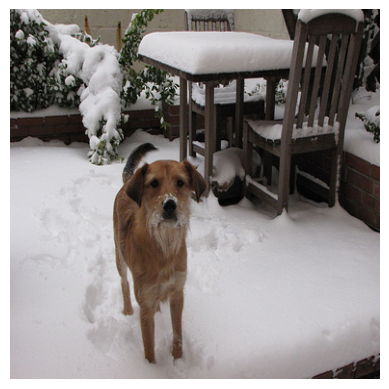

In [37]:
# either run this
# for images, targets in train_loader:
#     image = images[0]
#     break

# chosen_model(image.unsqueeze(0))
# plot_image(image)

################################################################################
# or this
chosen_model = chosen_model.to("cpu")
chosen_model(img)
plot_image(img.squeeze(0))

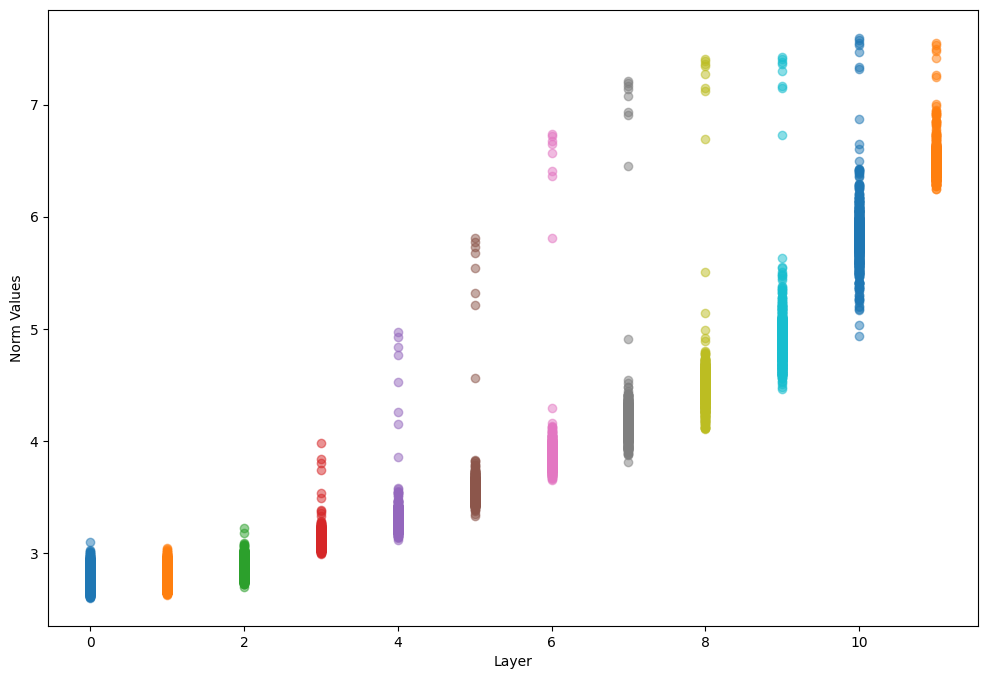

In [38]:
layer_norms = []
for x in range(12):
    layer_norms.append(torch.log(chosen_model.block_output['block'+ str(x)].squeeze()[1:,:].norm(dim = -1) + 1e-6).detach().numpy())
    # layer_norms.append(chosen_model.block_output['block'+ str(x)].squeeze()[1:,:].norm(dim = -1).detach().numpy())


plt.figure(figsize=(12, 8))  # Adjust the width and height as needed
for i, norms in enumerate(layer_norms):
    plt.scatter([i] * len(norms), norms, alpha=0.5)
plt.xlabel("Layer")
plt.ylabel("Norm Values")
plt.show()

In [39]:
def plot_norm_proportions(
    layer_norms,
    num_bins_layer: int = 100,
    num_bins_norm: int = 200,
    norm_range: tuple = (3, 300),
    cmap: str = "magma",
) -> None:
    """
    Plots the proportion of norm values across layers with a density heatmap.

    :param layer_norms: list of numpy arrays, each array contains the norm values for a specific layer.
    :param num_bins_layer: number of bins to divide the layers. Default is 100.
    :param num_bins_norm: number of bins to divide the norm values. Default is 200.
    :param norm_range: the min and max range for norm values.
    :param cmap: colormap to use for the heatmap.
    """
    # prepare bins for norms and layers
    all_layers = np.repeat(np.arange(len(layer_norms)), [len(x) for x in layer_norms])
    all_norms = np.hstack(layer_norms)
    layer_edges = np.linspace(0.5, len(layer_norms) + 0.5, num_bins_layer + 1)
    norm_edges = np.logspace(
        np.log10(norm_range[0]), np.log10(norm_range[1]), num_bins_norm + 1
    )

    # calculate histogram and normalize within each layer
    hist, _, _ = np.histogram2d(
        all_layers + 1, all_norms, bins=[layer_edges, norm_edges]
    )
    layer_totals = hist.sum(axis=1, keepdims=True)  # Total counts per layer
    proportions = hist / (layer_totals + 1e-6)  # Avoid division by zero

    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    ax.set_facecolor("black")  # set background to black

    # display the heatmap
    plt.imshow(
        proportions.T,
        aspect="auto",
        origin="lower",
        extent=[1, len(layer_norms), norm_edges[0], norm_edges[-1]],
        norm=LogNorm(vmin=1e-5, vmax=1),  # Avoid log(0) errors
        cmap=cmap,
    )

    plt.colorbar(label="Proportion")
    plt.yscale("log")
    plt.xlabel("Layer", fontsize=14)
    plt.ylabel("Norm", fontsize=14)
    plt.title("Proportion of Norms Across Layers", fontsize=16)
    plt.tight_layout()
    plt.show()

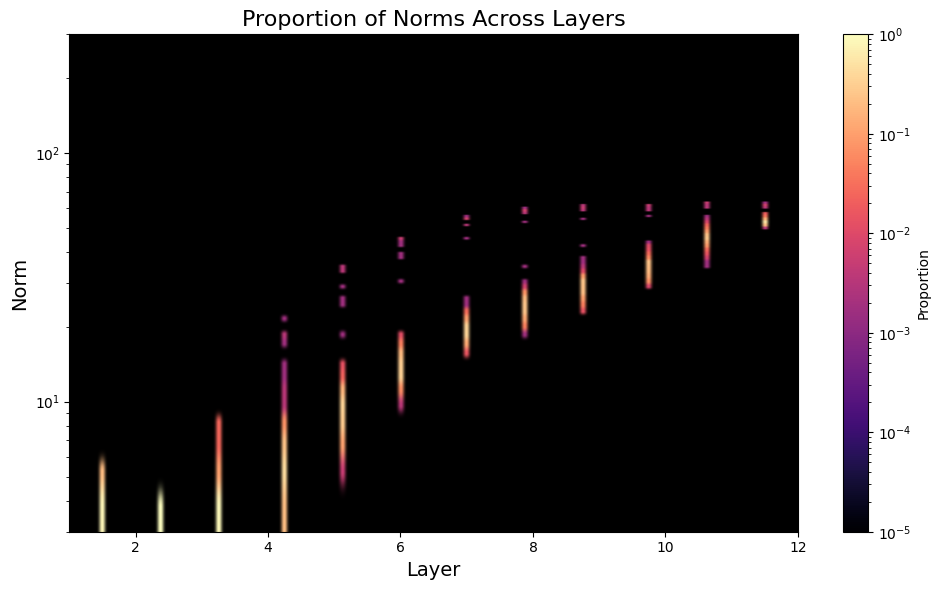

In [42]:
plot_norm_proportions(layer_norms)

### random stuff

In [32]:
model = small.to('cpu')

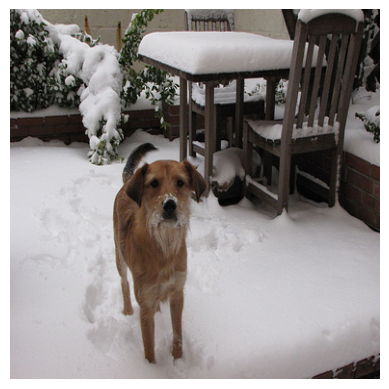

In [33]:
plot_image(img.squeeze(0))

In [34]:
model(img).shape

torch.Size([1, 1000])

In [69]:
x = model.patch_embed(img)
x = x + model.pos_embed

cls_token = model.cls_token.expand(img.shape[0], -1, -1)
x = torch.cat((cls_token, x), dim=1)

In [68]:
artifacts = find_high_norm_attn_intersection(model, block = 3)

In [96]:
new_x = model.block_output['block3'].squeeze(0)[1:,:] #torch.Size([576, 384])
cls_token_old = model.block_output['block3'].squeeze(0)[0,:].unsqueeze(0).unsqueeze(0) #torch.Size([1, 384])

In [86]:
new_x.shape

torch.Size([576, 384])

In [87]:
for x in artifacts:
    new_x[x] = torch.mean(torch.stack([new_x[(x+1) % 576], new_x[x-1], new_x[(x+24) % 576], new_x[x-24], new_x[(x+25) % 576], new_x[(x+23) % 576], new_x[x-25], new_x[x-23]]), dim=0)

In [88]:
def norm_progression(test_model=model, test_image=img, dots = []):
    test_model(test_image)

    num_blocks = 12
    num_cols = 6
    num_rows = (num_blocks + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 2.5))
    axes = axes.flatten()

    for i in range(num_blocks):
        output = test_model.block_output[f'block{i}']
        output = output.squeeze(0)
        output = output[1:]
        output_norms = output.norm(dim=-1)

        axes[i].imshow(output_norms.reshape(24, 24).detach().numpy())
        axes[i].axis('off')
        axes[i].set_title(f'Block {i}')

        dots = find_high_norm_attn_intersection(test_model, block = i)

        for dot in dots:
            axes[i].scatter(dot % 24, dot // 24, color='red', s=20)

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
        

    plt.tight_layout()
    plt.show()

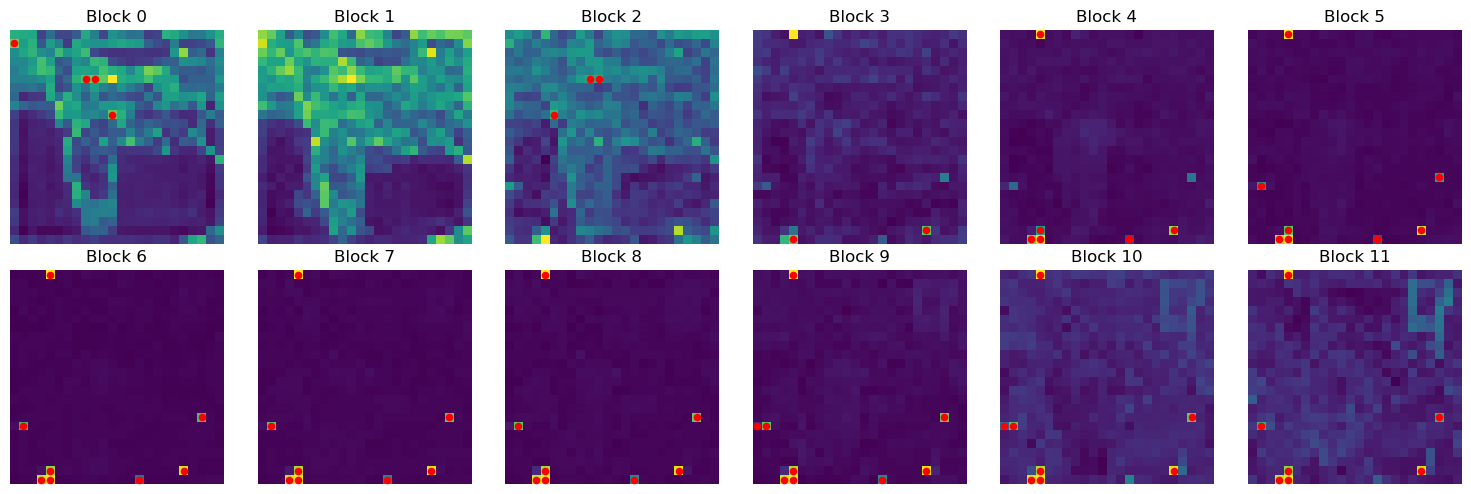

In [89]:
norm_progression(dots = artifacts)

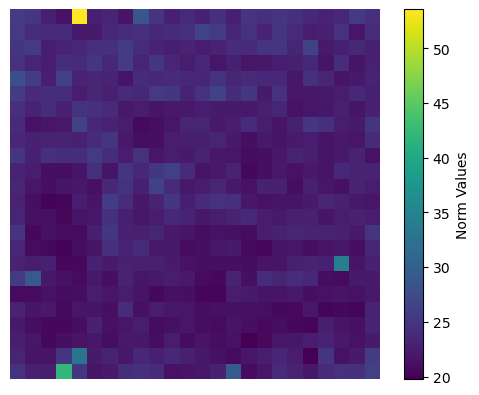

In [90]:
new_x.norm(dim=-1).reshape(24, 24)
plt.imshow(new_x.norm(dim=-1).reshape(24, 24).detach().numpy())
plt.axis('off')
plt.colorbar(label='Norm Values')
plt.show()

In [94]:
new_x.unsqueeze(0).shape

torch.Size([1, 576, 384])

In [97]:
cls_token_old.shape

torch.Size([1, 1, 384])

In [ ]:
newer_x = model.blocks[4](torch.cat((cls_token_old, new_x.unsqueeze(0)), dim=1))[:, 1:, :]
newer_cls_token = model.blocks[4](torch.cat((cls_token_old, new_x.unsqueeze(0)), dim=1))[:, 0, :]
newer_x.shape, newer_cls_token.shape

RuntimeError: Tensors must have same number of dimensions: got 3 and 4

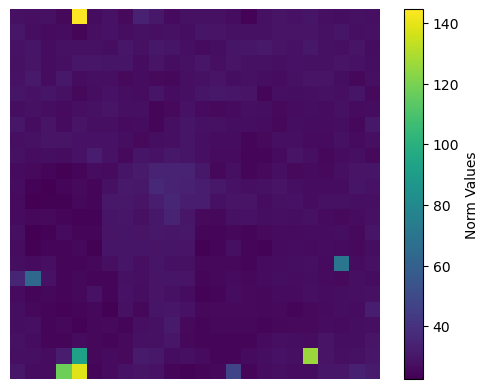

In [107]:
newer_x.norm(dim=-1).reshape(24, 24)
plt.imshow(newer_x.norm(dim=-1).reshape(24, 24).detach().numpy())
plt.axis('off')
plt.colorbar(label='Norm Values')
plt.show()

In [224]:
def full_progression(model = model, img = img):
    x = model.patch_embed(img)
    x = x + model.pos_embed
    cls_token = model.cls_token.expand(img.shape[0], -1, -1)
    x = torch.cat((cls_token, x), dim=1)

    history = dict()
    before_change = dict()

    new_x = model.block_output[f'block{3}'][:, 1:, :]
    cls_token_old = model.block_output[f'block{3}'][:, 0, :].unsqueeze(0)

    for i in range(3, 11):
        artifacts = find_high_norm_attn_intersection(model, block = i)
        
        for j in artifacts[0]:
            
            j = torch.tensor(j)


            new_x = new_x.squeeze(0)
            full_stack = torch.stack([new_x[(j+1) % 576].clone(), new_x[j-1].clone(), new_x[(j+24) % 576].clone(), new_x[j-24].clone(), new_x[(j+25) % 576].clone(), new_x[(j+23) % 576].clone(), new_x[j-25].clone(), new_x[j-23].clone()])
            probe = new_x[j]
            new_x[j] = torch.mean(full_stack, dim=0)
            print(probe == torch.mean(full_stack, dim=0))
            new_x = new_x.unsqueeze(0)

        before_change[i] = (new_x)

        new_x = model.blocks[i + 1](torch.cat((cls_token_old, new_x), dim=1))[:, 1:, :]

        history[i + 1] = (new_x)
        
        cls_token_old = model.blocks[i](torch.cat((cls_token_old, new_x), dim=1))[:, 0, :].unsqueeze(0)

    #plot history
    num_blocks = 12
    num_cols = 6
    num_rows = (num_blocks + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 2.5))
    axes = axes.flatten()

    for i in range(4, 12):
        output = history[i]
        output_norms = output.norm(dim=-1)

        axes[i].imshow(output_norms.reshape(24, 24).detach().numpy())
        axes[i].axis('off')
        axes[i].set_title(f'Block {i}')

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


    #plot before change
    num_blocks = 12
    num_cols = 6
    num_rows = (num_blocks + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 2.5))
    axes = axes.flatten()

    for i in range(3, 11):
        output = before_change[i]
        output_norms = output.norm(dim=-1)

        axes[i].imshow(output_norms.reshape(24, 24).detach().numpy())
        axes[i].axis('off')
        axes[i].set_title(f'Block {i}')

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    

In [225]:
artifacts[0]

array([547, 556])

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

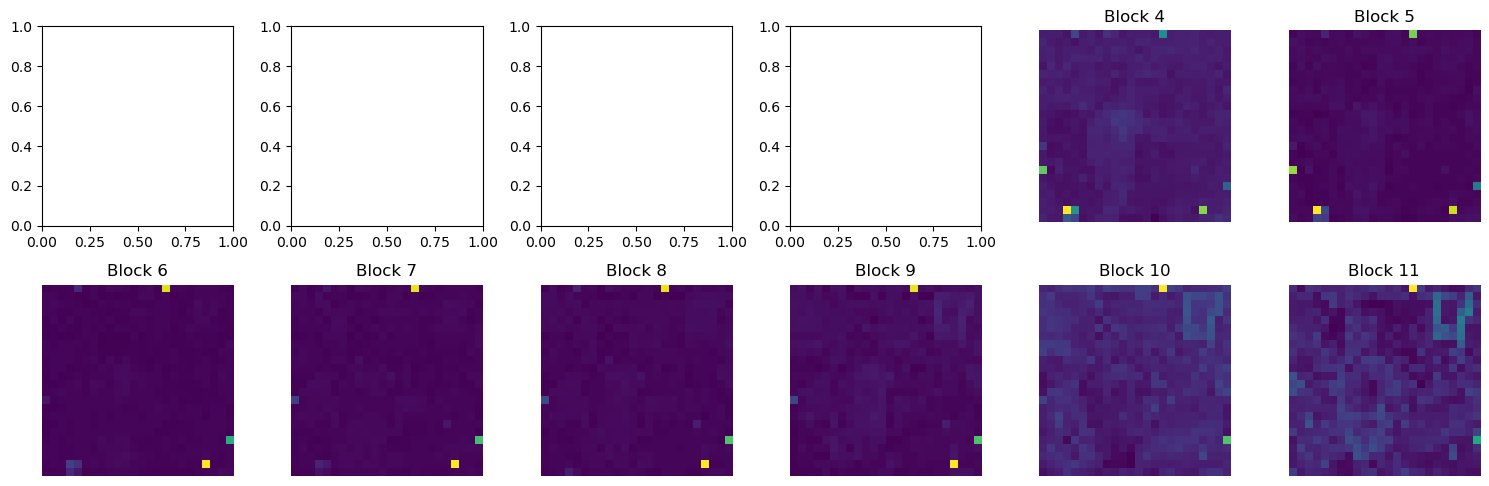

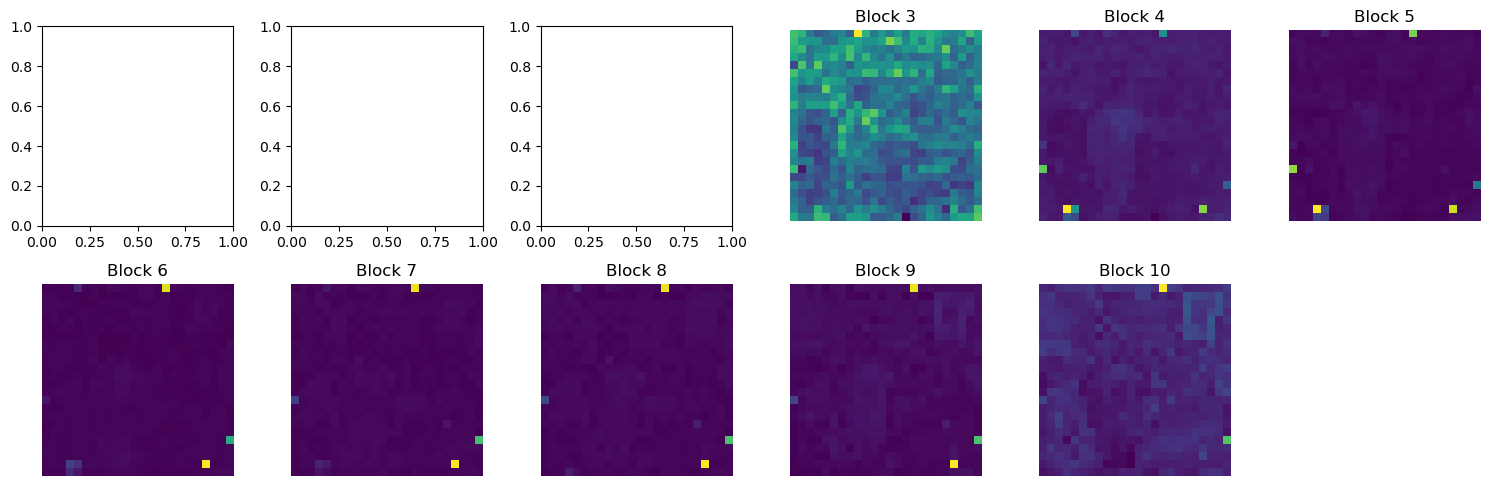

In [226]:
full_progression()

In [71]:
for i, block in enumerate(model.blocks):
    x = block(x)

x = model.norm(x)
x_cls = x[:, 0]
x = model.head(x_cls)